In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import seaborn

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
#Determine the tables in the schema
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
#Review the colums in measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Earliest Date
earliest = session.query(Measurement.date).order_by(Measurement.date).first()
earliest 

('2010-01-01')

In [12]:
# Latest Date
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest

('2017-08-23')

In [13]:
# Calculate the date 1 year ago from the last data point in the database
year_before_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Year Before Date: ", year_before_date)

Year Before Date:  2016-08-23


In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_twelve = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_before_date)
last_df = pd.read_sql_query(last_twelve.statement , engine, index_col= 'date')
last_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


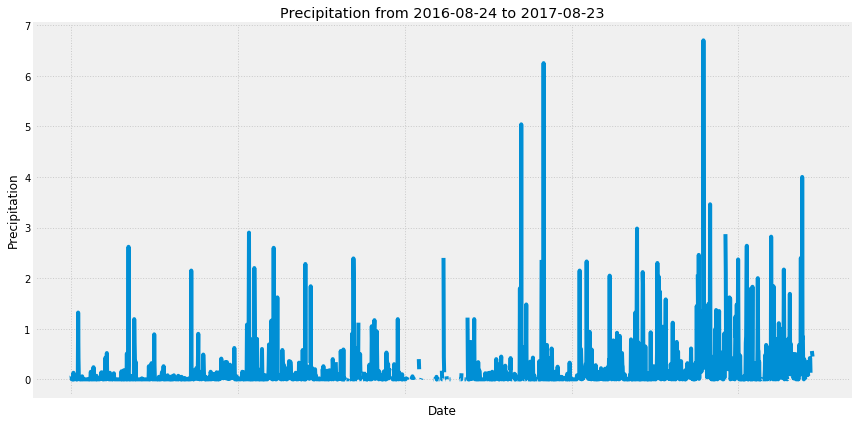

In [148]:
# Use Pandas Plotting with Matplotlib to plot the data
last_df.plot(figsize = (12, 6), rot= 45, use_index=True, legend=False)
plt.ylabel('Precipitation')
plt.xlabel('Date')
plt.title ('Precipitation from 2016-08-24 to 2017-08-23')
plt.grid(linestyle='dotted')
plt.tight_layout()

plt.show()

In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [28]:
#Review the columns in the station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [25]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [59]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station,
func.count(Measurement.id)).filter(Station.station ==Measurement.station).group_by(Measurement.station).order_by(func.count
(Measurement.tobs).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [96]:
# Choose the station with the highest number of temperature observations.
station_data = pd.read_sql('SELECT * FROM Measurement', con=engine).reset_index(drop=True)

stat_1 = station_data.loc[station_data['station'] == 'USC00519281',:]
stat_1.head()

,id,station,date,prcp,tobs
12187,12188,USC00519281,2010-01-01,0.15,70.0
12188,12189,USC00519281,2010-01-02,0.00,62.0
12189,12190,USC00519281,2010-01-03,0.00,74.0
12190,12191,USC00519281,2010-01-04,0.00,75.0
12191,12192,USC00519281,2010-01-05,0.00,74.0


In [97]:
# Query the last 12 months of temperature observation data for this station 
year_stat_1 = stat_1[(stat_1['date'] > '2016-08-23') & (stat_1['date'] <= '2017-08-23')]
year_stat_1.head()

,id,station,date,prcp,tobs
14608,14609,USC00519281,2016-08-24,2.15,77.0
14609,14610,USC00519281,2016-08-25,0.06,80.0
14610,14611,USC00519281,2016-08-26,0.01,80.0
14611,14612,USC00519281,2016-08-27,0.12,75.0
14612,14613,USC00519281,2016-08-28,0.60,73.0


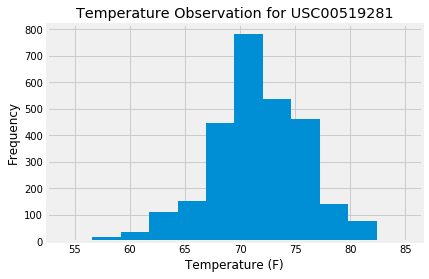

In [98]:
#Plot the results as a histogram
x = stat_1['tobs']
plt.hist(x, bins=12)
plt.title("Temperature Observation for USC00519281")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")

plt.show()

In [94]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
trip_min = stat_1['tobs'].min()
trip_avg = stat_1['tobs'].mean()
trip_max = stat_1['tobs'].max()
print(trip_min, trip_avg, trip_max)

54.0 71.66378066378067 85.0


In [141]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [142]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-02-28', '2016-03-05'))

[(62.0, 69.88636363636364, 80.0)]


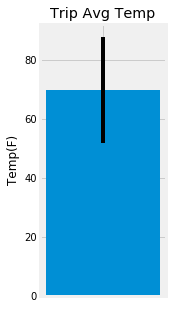

In [143]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

TMAX = 80.0
TMIN = 62.0
TAVE = 69.89
yerr = TMAX - TMIN

plt.figure(figsize=(2,5))
plt.bar(1, TAVE, yerr=yerr, align='center', tick_label = "")
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')

plt.show()

In [145]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
precip_data = pd.read_sql('SELECT * FROM Measurement', con=engine).reset_index(drop=True)
year_precip = precip_data[(precip_data['date'] > '2017-02-28') & (precip_data['date'] <= '2017-03-05')]
year_precip.head()

,id,station,date,prcp,tobs
2553,2554,USC00519397,2017-03-01,1.19,66.0
2554,2555,USC00519397,2017-03-02,0.73,73.0
2555,2556,USC00519397,2017-03-03,0.47,69.0
2556,2557,USC00519397,2017-03-04,0.00,74.0
2557,2558,USC00519397,2017-03-05,0.35,71.0


## Optional Challenge Assignment

In [146]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
def daily_normals:
    temps = session.query(Measurement.tobs).filter(Measurement.date.like(
    obs=
    s_date='2018-01-01'
    e_date='2018-01-07'
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df=pd.Dataframe(results('2018-01-01', '2018-01-07')).set_index('date')
df

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


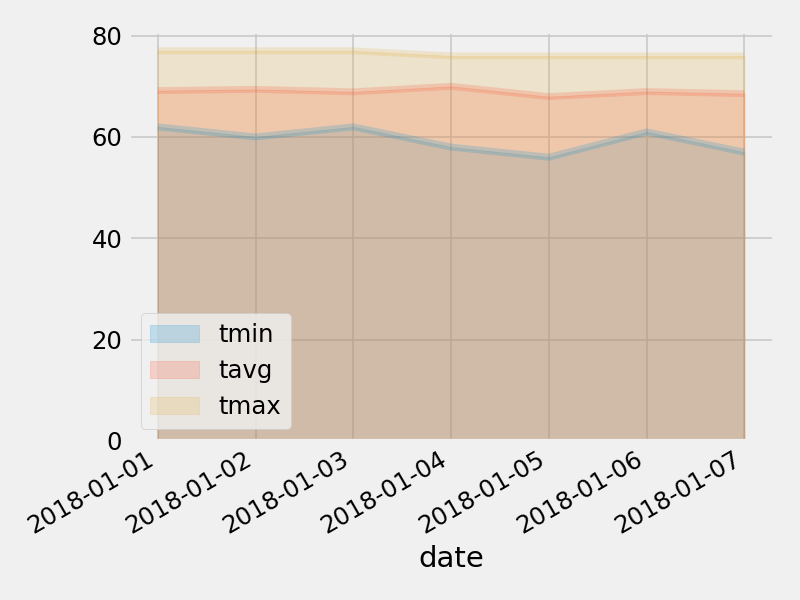

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
df = df[['tmax', 'tavg', 'tmin']]
df.plot(kind = 'area', stacked=False, alpha=0.75, rot=45, color=[''])
plt.xlabel('Date')
plt.ylabe('Temperature (F)')
plt.legend(frameon = True)
plt.show()